In [2]:
import numpy as np
import tensorflow as tf
from scipy.stats import truncnorm

2023-04-27 19:08:15.112585: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
class MetaDataset:
    def __init__(self, random_state=None):
        if random_state is None:
            self.random_state = np.random
        else:
            self.random_state = random_state

    def generate_meta_train_data(self, n_tasks: int, n_samples: int) -> list:
        raise NotImplementedError

    def generate_meta_test_data(self, n_tasks: int, n_samples_context: int, n_samples_test: int) -> list:
        raise NotImplementedError

In [4]:
def provide_data(dataset, seed=28, n_train_tasks=None, n_samples=None, config=None):
    import numpy as np

    N_TEST_TASKS = 20
    N_VALID_TASKS = 20
    N_TEST_SAMPLES = 200

    # if specified, overwrite default settings
    if config is not None:
        if config['num_test_valid_tasks'] is not None: N_TEST_TASKS = config['num_test_valid_tasks']
        if config['num_test_valid_tasks'] is not None: N_VALID_TASKS = config['num_test_valid_tasks']
        if config['num_test_valid_samples'] is not None:  N_TEST_SAMPLES = config['num_test_valid_samples']
            
            
    elif 'cauchy' in dataset:
        if len(dataset.split('_')) == 2:
            n_train_tasks = int(dataset.split('_')[-1])

        dataset = CauchyMetaDataset(random_state=np.random.RandomState(seed + 1))

        if n_samples is None:
            n_train_samples = n_context_samples = 20
        else:
            n_train_samples = n_context_samples = n_samples

        if n_train_tasks is None: n_train_tasks = 20
            
    elif 'sinc' in dataset:
        if len(dataset.split('_')) == 2:
            n_train_tasks = int(dataset.split('_')[-1])

        dataset = Sinc_MetaDataset(random_state=np.random.RandomState(seed + 1))

        if n_samples is None:
            n_train_samples = n_context_samples = 20
        else:
            n_train_samples = n_context_samples = n_samples

        if n_train_tasks is None: n_train_tasks = 20
            
    elif 'movingaverages' in dataset:
        if len(dataset.split('_')) == 2:
            n_train_tasks = int(dataset.split('_')[-1])

        dataset = moving_Sinc_MetaDataset(random_state=np.random.RandomState(seed + 1))

        if n_samples is None:
            n_train_samples = n_context_samples = 20
        else:
            n_train_samples = n_context_samples = n_samples

        if n_train_tasks is None: n_train_tasks = 20
            
    else:
        raise NotImplementedError('Does not recognize dataset flag')

    data_train = dataset.generate_meta_train_data(n_tasks=n_train_tasks, n_samples=n_train_samples)

    data_test_valid = dataset.generate_meta_test_data(n_tasks=N_TEST_TASKS + N_VALID_TASKS,
                                                      n_samples_context=n_context_samples,
                                                      n_samples_test=N_TEST_SAMPLES)
    data_valid = data_test_valid[N_VALID_TASKS:]
    data_test = data_test_valid[:N_VALID_TASKS]

    return data_train, data_valid, data_test

In [5]:
class moving_Sinc_MetaDataset(MetaDataset):

    def __init__(self, noise_std=0.05, ndim_x=2, random_state=None):
        self.noise_std = noise_std
        self.ndim_x = ndim_x
        self.x_low = -10
        self.x_high = 10
        super().__init__(random_state)

    def generate_meta_train_data(self, n_tasks, n_samples):
        meta_train_tuples = []
        for i in range(n_tasks):
            mu1 = np.zeros((self.ndim_x,))
            mu2 = truncnorm.rvs(self.x_low, self.x_high, loc=0, scale=3, size=(self.ndim_x,))
            X = self.random_state.uniform(self.x_low, self.x_high, size=(n_samples, self.ndim_x))
            Y = self._gp_fun_from_prior(X, mu1, mu2)
            meta_train_tuples.append((X, Y))
        return meta_train_tuples

    def generate_meta_test_data(self, n_tasks, n_samples_context, n_samples_test):
        assert n_samples_test > 0
        meta_test_tuples = []
        for i in range(n_tasks):
            mu1 = np.zeros((self.ndim_x,))
            mu2 = truncnorm.rvs(self.x_low, self.x_high, loc=0, scale=3, size=(self.ndim_x,))
            X = self.random_state.uniform(self.x_low, self.x_high, size=(n_samples_context + n_samples_test, self.ndim_x))
            Y = self._gp_fun_from_prior(X, mu1, mu2)
            meta_test_tuples.append(
                (X[:n_samples_context], Y[:n_samples_context], X[n_samples_context:], Y[n_samples_context:]))

        return meta_test_tuples
    
    def sinc_mean(self, x, mu1, mu2):
        sinc1 = np.sin(np.linalg.norm(x - mu1, axis=-1))/np.linalg.norm(x - mu1, axis=-1)
        sinc2 = np.sin(np.linalg.norm(x - mu2, axis=-1))/np.linalg.norm(x - mu2, axis=-1)
        return sinc1 + 2 * sinc2

    def _gp_fun_from_prior(self, X, mu1, mu2):
        assert X.ndim == 2

        n = X.shape[0]

        def kernel(a, b, lengthscale):
            sqdist = np.sum(a ** 2, 1).reshape(-1, 1) + np.sum(b ** 2, 1) - 2 * np.dot(a, b.T)
            return np.exp(-.5 * (1 / lengthscale) * sqdist)

        K_ss = kernel(X, X, 0.5)
        L = np.linalg.cholesky(K_ss + 1e-8 * np.eye(n))
        f = self.sinc_mean(X, mu1, mu2)
        y = f + self.random_state.normal(scale=self.noise_std, size=f.shape)
        return y.reshape(-1, 1)

20
200


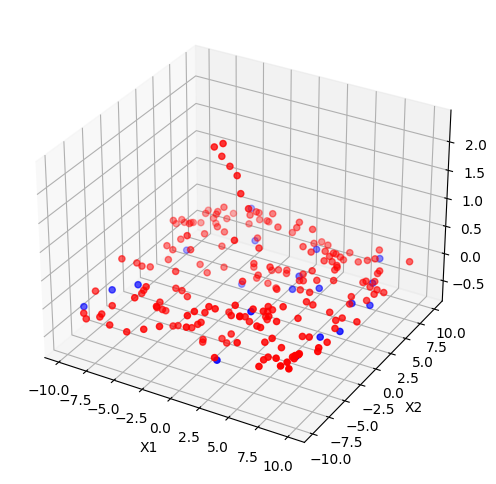

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

meta_train_data, meta_test_data, _ = provide_data(dataset='movingaverages_20', n_samples=20)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

for i in range(1):
    X_context, Y_context, X_test, Y_test = meta_test_data[i]
    print(len(Y_context))
    print(len(Y_test))
    ax.scatter(X_context[:, 0], X_context[:, 1], Y_context, c='b', marker='o')
    ax.scatter(X_test[:, 0], X_test[:, 1], Y_test, c='r', marker='o')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')

plt.show()

In [7]:
tf.get_logger().setLevel('ERROR')

#choose number of tasks here
meta_train_data, meta_test_data, _ = provide_data(dataset='movingaverages_20', n_train_tasks=20, n_samples=20)

from pacoh_nn.pacoh_nn_regression import PACOH_NN_Regression
pacoh_model = PACOH_NN_Regression(meta_train_data, prior_weight=0.184, bandwidth=480.,
                                  hyper_prior_likelihood_log_var_mean_mean=-1.0,
                                  hyper_prior_log_var_mean=-1.74, hyper_prior_nn_std=0.12,
                                  hyper_prior_weight=1e-5, lr=1.5e-3, learn_likelihood=True,
                                  random_seed=28, num_iter_meta_train=20000)

pacoh_model.meta_fit(meta_test_data[:10], eval_period=10000, log_period=1000, plot_period=5000)

eval_metrics_mean, eval_metrics_std = pacoh_model.meta_eval_datasets(meta_test_data)
for key in eval_metrics_mean:
    print("%s: %.4f +- %.4f" % (key, eval_metrics_mean[key], eval_metrics_std[key]))


2023-04-27 19:08:51.072253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [20,1]
	 [[{{node Placeholder/_1}}]]
2023-04-27 19:08:51.081751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [20,1]
	 [[{{node Placeholder/_1}}]]
2023-04-27 19:08:51.092250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [20,2]
	

Start meta-training -------------------- 


2023-04-27 19:09:10.809543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]



Iter 0/20000 - Time 38.41 sec - Train-Loss: -4286.77393

Iter 1000/20000 - Time 20.97 sec - Train-Loss: -351.25754

Iter 2000/20000 - Time 20.47 sec - Train-Loss: -310.39072

Iter 3000/20000 - Time 21.27 sec - Train-Loss: -376.86523

Iter 4000/20000 - Time 20.72 sec - Train-Loss: -301.58398

Iter 5000/20000 - Time 21.09 sec - Train-Loss: -308.19089

Iter 6000/20000 - Time 20.24 sec - Train-Loss: -234.43561

Iter 7000/20000 - Time 21.14 sec - Train-Loss: -181.85902

Iter 8000/20000 - Time 22.49 sec - Train-Loss: -118.27189

Iter 9000/20000 - Time 22.42 sec - Train-Loss: -41.79527


2023-04-27 19:13:07.996324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [20,2]
	 [[{{node Placeholder/_0}}]]
2023-04-27 19:13:08.009855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [200,2]
	 [[{{node Placeholder/_0}}]]
2023-04-27 19:13:08.019972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [20,1]


	Start meta-test posterior inference in 2 batches ------------------
	Meta-Test batch #1 consisting of 5 tasks----


2023-04-27 19:13:18.391653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-27 19:13:18.445168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_16' with dtype int32
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_16}}]]
2023-04-27 19:13:18.539635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this

	Meta-Test batch #2 consisting of 5 tasks----

Iter 10000/20000 - Time 20.63 sec - Train-Loss: -22.97465- Val-cal_err: 0.076 +- 0.020- Val-avg_rmse: 0.413 +- 0.064- Val-avg_ll: -0.708 +- 0.456

Iter 11000/20000 - Time 31.29 sec - Train-Loss: -11.13470

Iter 12000/20000 - Time 20.54 sec - Train-Loss: -9.85955

Iter 13000/20000 - Time 23.47 sec - Train-Loss: -11.87144

Iter 14000/20000 - Time 21.18 sec - Train-Loss: -8.55691

Iter 15000/20000 - Time 21.59 sec - Train-Loss: -9.75821

Iter 16000/20000 - Time 21.25 sec - Train-Loss: -8.14794

Iter 17000/20000 - Time 21.21 sec - Train-Loss: -6.88693

Iter 18000/20000 - Time 21.67 sec - Train-Loss: -6.70499

Iter 19000/20000 - Time 21.43 sec - Train-Loss: -7.79438


2023-04-27 19:21:22.965864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [20,2]
	 [[{{node Placeholder/_0}}]]
2023-04-27 19:21:22.986899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200,1]
	 [[{{node Placeholder/_1}}]]
2023-04-27 19:21:23.003154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [20,2]


2023-04-27 19:21:23.381609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [200,1]
	 [[{{node Placeholder/_1}}]]
2023-04-27 19:21:23.395725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [20,1]
	 [[{{node Placeholder/_1}}]]
2023-04-27 19:21:23.408348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [200,2]

	Start meta-test posterior inference in 4 batches ------------------
	Meta-Test batch #1 consisting of 5 tasks----
	Meta-Test batch #2 consisting of 5 tasks----
	Meta-Test batch #3 consisting of 5 tasks----
	Meta-Test batch #4 consisting of 5 tasks----
cal_err: 0.0410 +- 0.0146
avg_rmse: 0.3918 +- 0.0635
avg_ll: -0.2919 +- 0.1828
